In [ ]:
!pip install timm

In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as T
from tqdm.notebook import tqdm
from torch import nn
from itertools import islice

import os
import random
import timm
import matplotlib.image as img
import matplotlib.pyplot as plt

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
% cd drive/MyDrive/competitions_egor/zindi_sign_lang

/content/drive/MyDrive/competitions_egor/zindi_sign_lang


In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [12]:
def get_transforms(size=224, train=True):
    if train:
        transform = T.Compose([
            T.Resize(256),
            T.RandomCrop(224),
            T.ToTensor(),
            T.RandomHorizontalFlip(),
            T.ColorJitter(),
            T.Normalize(mean=[0.4684, 0.4047, 0.3887],
                        std=[0.2618, 0.2341, 0.2249]),
        ])

    else:
        transform = T.Compose([
            T.Resize(256),
            T.RandomCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.4684, 0.4047, 0.3887],
                        std=[0.2618, 0.2341, 0.2249]),
        ])

    return transform

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [13]:
set_random_seed(0)

TRAIN = 'data/Images/train'
VAL = 'data/Images/val'
TEST = 'data/Images/test'

train_dataset = torchvision.datasets.ImageFolder(TRAIN, transform=get_transforms(train=True))
val_dataset = torchvision.datasets.ImageFolder(VAL, transform=get_transforms(train=False))
test_dataset = torchvision.datasets.ImageFolder(TEST, transform=get_transforms(train=False))

In [14]:
def plot_losses(train_losses, test_losses):
    clear_output()
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    ax.plot(range(1, len(test_losses) + 1), test_losses, label='test')
    ax.set_ylabel('loss')

    ax.grid()
    ax.set_xlabel('epoch')
    ax.legend()

    plt.show()

def train_one_epoch(model, train_loader, criterion, optimizer, device="cuda:0", iters=None, log=False):
    log_iters = 5

    model.train()
    running_loss = 0.0
    for iter, (images, labels) in enumerate(islice(tqdm(train_loader), iters)):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]

        if log and iter % log_iters == 0:
            print('Iteration: {}, Loss: {}'.format(iter, loss.item()))
        
    return running_loss


def predict(model, val_loader, criterion, device="cuda:0", num_classes=9):
    model.eval()
    predicted_logits = torch.zeros((len(val_loader.dataset), num_classes))
    predicted_classes = torch.zeros(len(val_loader.dataset))
    true_classes = torch.zeros(len(val_loader.dataset))
    running_loss = 0.0
    pad = 0
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        running_loss += loss.item() * images.shape[0]
        true_classes[pad:pad + len(labels)] = labels
        predicted_logits[pad:pad + len(labels)] = logits
        predicted_classes[pad:pad + len(labels)] = logits.argmax(dim=-1)
        pad += len(labels)

    return running_loss, predicted_logits, predicted_classes, true_classes


def train(model, train_loader, val_loader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = [] 

    for epoch in range(n_epochs):
        train_loss = train_one_epoch(
            model, train_loader,
            criterion, optimizer,
            device
        )
        val_loss, _, predicted_classes, true_classes = predict(
            model, val_loader, criterion, device
        )
        train_losses.append(train_loss / len(train_loader.dataset))
        val_losses.append(val_loss / len(val_loader.dataset))

        plot_losses(train_losses, val_losses)

        if scheduler is not None:
            scheduler.step(val_losses[-1])

In [15]:
model = timm.create_model('resnetv2_50x1_bit_distilled', pretrained=True, num_classes=9)
# тренируем только последние слои
for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-3, weight_decay=1e-4, )
criterion = nn.CrossEntropyLoss()

model.to(device)

In [18]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=2,
    shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=64, 
    pin_memory=True, 
    num_workers=2, 
    shuffle=False
)

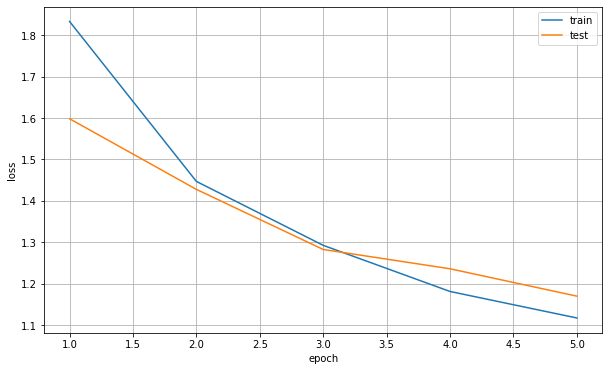

In [19]:
# train_one_epoch(model, train_dataloader, criterion, optimizer, device, log=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs=5, scheduler=scheduler)

In [20]:
# включаем градиенты
for param in model.parameters():
    param.requires_grad = True

In [21]:
# делаем батч поменьше
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    pin_memory=True,
    num_workers=2,
    shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=64, 
    pin_memory=True, 
    num_workers=2, 
    shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, 
    pin_memory=True, 
    num_workers=2, 
    shuffle=False
)

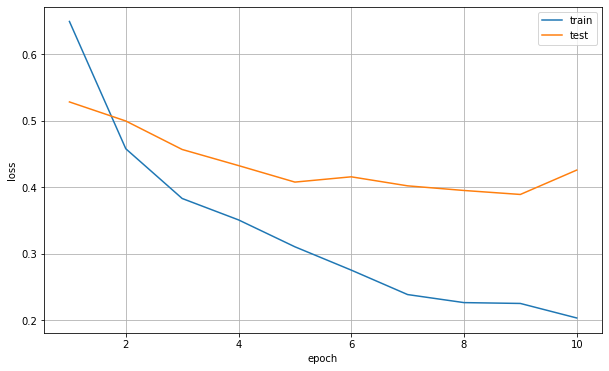

  0%|          | 0/15 [00:00<?, ?it/s]

0.4225438819991218

In [22]:
# теперь оптимизируем все, но чуть-чуть
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=0)

train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs=10, scheduler=scheduler)
# train_one_epoch(model, train_dataloader, criterion, optimizer, device, log=True)

all_losses, predicted_logits, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
all_losses / len(val_dataloader.dataset)

In [23]:
all_losses, predicted_logits, predicted_labels, true_labels = predict(model, test_dataloader, criterion, device)

  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
test.columns

Index(['img_IDS'], dtype='object')

In [25]:
sub = pd.read_csv('data/SampleSubmission.csv')

cols = sub.columns

sub = pd.DataFrame(
    data=torch.nn.functional.softmax(predicted_logits, dim=-1).detach().numpy(),
    columns=['Church', 'Friend', 'Love', 'Me', 'Mosque', 'Enough/Satisfied', 'Seat', 'Temple', 'You'],
    index=[x[0].split('/')[-1].split('.')[0] for x in test_dataset.imgs]
)

sub.reset_index().rename({'index': 'img_IDS'}, axis=1)[cols].to_csv('data/submissions/egor11.csv', index=False)